# Sparse NN autoencoder on STFT data, db units

Taken from https://github.com/pkmital/tensorflow_tutorials/blob/master/python/08_denoising_autoencoder.py

In [1]:
from __future__ import division, print_function, absolute_import
%pylab inline

import tensorflow as tf
import numpy as np
import os
import librosa
import librosa.display
from  librosa.util import frame
from scipy.signal import resample

%run ../utils.py
%run nnutils.py
    
rc_default()

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = "../wavs/"
fname = 'Grisey_partiels.wav'
# fname = 'Stockhausen_Gruppen.wav'
fname = 'Bowie_Changes.wav'
# fname = 'Reich_Music18.wav'
# fname = 'Dirty_CannibalResource.wav'

name = fname[:-4]

# fs,track = fragment_from_wav(path+fname,0,168)
# fs,track = fragment_from_wav(path+fname,0,180)
# track = resample(track,int(track.size/2.0))

# fs = fs/2.0

track, fs = librosa.load(path+fname)

NFFT = 2**11
HOP = int(NFFT/4)

STFT = librosa.stft(track,n_fft=NFFT, hop_length=HOP,center=True).T

X = abs(STFT/float(NFFT)/2)**2

Xref = 1e-12

In [3]:
# figure(figsize=(14,4))
# librosa.display.specshow(log10(X.T/Xref).clip(0),hop_length = HOP, sr=fs,y_axis='linear', fmax=8000, x_axis='time')
# colorbar(label='Intensity (dB)');

In [4]:
print("Dimensions: freq bins, time bins")
X = X[:,:NFFT//2]
time_bins,freq_bins = X.shape
print(freq_bins,time_bins)

Dimensions: freq bins, time bins
1024 9322


## Create dataset  (Data class) with spectrum

In [5]:
from sklearn.preprocessing import MinMaxScaler      

Xlog = log10(X/Xref).clip(0)

scaler = (1,0)

Xnorm = (Xlog-scaler[1])/scaler[0]

print(Xnorm.min(),Xnorm.max())

data = Data( Xnorm )

0.0 9.04334


## Neural Autoencoder parameters

In [23]:
display_step = 10
batch_size = 200
n_epochs = 300
learning_rate_1 = 0.002
learning_rate_2 = 0.0003

l2scale_1 = 0.003
l2scale_2 = 0.006

sparse_scale_1 = 0.4
sparse_scale_2 = 0.65
dimensions= [512,256,128,64,32,16,8]
# dimensions= [512,128,32,8]
activation = tf.nn.tanh
activation = tf.nn.softplus
# activation = parametric_relu
# activation = tf.nn.relu
bias = True
stddev = 0.01
meaninit = 0.01
alpha = 0.995

tolerance_1 = 1e-7
tolerance_2 = 1e-8

In [24]:
data_in = data
d_prev = freq_bins
Ws = []
bs = []
cost_sparse = []
cost_l2 = []
cost_base = []
cost_smooth = []

for d in dimensions:

    ae = SAE(d_prev,[d],activation=activation,bias=bias,
              sparse_scale=sparse_scale_1,l2scale=l2scale_1,learning_rate=learning_rate_1,
              identity_initializer=False, stddev=stddev,meaninit=meaninit)

    ae.init_session()

    ae.train(data_in, batch_size, tolerance=tolerance_1, alpha = alpha)

    sess = ae.get_session()
    variable_dict = ae.get_variables_dict()
    Ws.append( variable_dict['W'][0].eval(session=sess) )
    bs.append( variable_dict['b'][0].eval(session=sess) )
    Z = sess.run(variable_dict['z'], feed_dict={ variable_dict['X']: data_in.data})
    data_in = Data(Z)
    d_prev = d
    
    cost_base += ae.cost_base_list
    cost_l2 += ae.reg_l2_list
    cost_sparse += ae.reg_sparse_list
    cost_smooth += ae.cost_list
    

Epoch: 0000 cost= 6.591014862
Epoch: 0010 cost= 6.442194595
Epoch: 0020 cost= 6.244084806
Epoch: 0030 cost= 6.035374675
Epoch: 0040 cost= 5.832519828
Epoch: 0050 cost= 5.636652129
Epoch: 0060 cost= 5.450894451
Epoch: 0070 cost= 5.273494333
Epoch: 0080 cost= 5.104917995
Epoch: 0090 cost= 4.943791829
Epoch: 0100 cost= 4.790842933
Epoch: 0110 cost= 4.645060062
Epoch: 0120 cost= 4.503459463
Epoch: 0130 cost= 4.370113905
Epoch: 0140 cost= 4.243801916
Epoch: 0150 cost= 4.123052899
Epoch: 0160 cost= 3.997732830
Epoch: 0170 cost= 3.876751849
Epoch: 0180 cost= 3.762260384
Epoch: 0190 cost= 3.654200471
Epoch: 0200 cost= 3.524359086
Epoch: 0210 cost= 3.379023947
Epoch: 0220 cost= 3.238965092
Epoch: 0230 cost= 3.104251160
Epoch: 0240 cost= 2.975092370
Epoch: 0250 cost= 2.851163111
Epoch: 0260 cost= 2.732184835
Epoch: 0270 cost= 2.618059207
Epoch: 0280 cost= 2.508503202
Epoch: 0290 cost= 2.403207189
Epoch: 0300 cost= 2.302602786
Epoch: 0310 cost= 2.206467820
Epoch: 0320 cost= 2.114874704
Epoch: 033

Epoch: 0950 cost= 0.220445604
Epoch: 0960 cost= 0.212814470
Epoch: 0970 cost= 0.205571023
Epoch: 0980 cost= 0.198679617
Epoch: 0990 cost= 0.192117942
Epoch: 1000 cost= 0.185880607
Epoch: 1010 cost= 0.179952561
Epoch: 1020 cost= 0.174309070
Epoch: 1030 cost= 0.168946341
Epoch: 1040 cost= 0.163845117
Epoch: 1050 cost= 0.158980778
Epoch: 1060 cost= 0.154360806
Epoch: 1070 cost= 0.149966809
Epoch: 1080 cost= 0.145783299
Epoch: 1090 cost= 0.141811244
Epoch: 1100 cost= 0.138036338
Epoch: 1110 cost= 0.134439349
Epoch: 1120 cost= 0.131022680
Epoch: 1130 cost= 0.127768977
Epoch: 1140 cost= 0.124675671
Epoch: 1150 cost= 0.121736839
Epoch: 1160 cost= 0.118940747
Epoch: 1170 cost= 0.116277155
Epoch: 1180 cost= 0.113750054
Epoch: 1190 cost= 0.111343585
Epoch: 1200 cost= 0.109051551
Epoch: 1210 cost= 0.106882208
Epoch: 1220 cost= 0.104815367
Epoch: 1230 cost= 0.102849850
Epoch: 1240 cost= 0.100970684
Epoch: 1250 cost= 0.099183601
Epoch: 1260 cost= 0.097483546
Epoch: 1270 cost= 0.095874543
Epoch: 128

Epoch: 1540 cost= 0.070559408
Epoch: 1550 cost= 0.070479426
Epoch: 1560 cost= 0.070521594
Epoch: 1570 cost= 0.070432572
Epoch: 1580 cost= 0.070346126
Epoch: 1590 cost= 0.070263913
Epoch: 1600 cost= 0.070173907
Epoch: 1610 cost= 0.070103864
Epoch: 1620 cost= 0.070052679
Epoch: 1630 cost= 0.069966584
Epoch: 1640 cost= 0.069926671
Epoch: 1650 cost= 0.069937402
Epoch: 1660 cost= 0.069907522
Epoch: 1670 cost= 0.069866678
Epoch: 1680 cost= 0.069825254
Epoch: 1690 cost= 0.069765644
Epoch: 1700 cost= 0.069796872
Epoch: 1710 cost= 0.069756406
Epoch: 1720 cost= 0.069707962
Epoch: 1730 cost= 0.069705813
Epoch: 1740 cost= 0.069662019
Epoch: 1750 cost= 0.069622927
8.66539685285e-08
Optimization Finished!
Epoch: 0000 cost= 4.285155773
Epoch: 0010 cost= 4.134920442
Epoch: 0020 cost= 3.959285446
Epoch: 0030 cost= 3.782257342
Epoch: 0040 cost= 3.609738194
Epoch: 0050 cost= 3.443351502
Epoch: 0060 cost= 3.283965221
Epoch: 0070 cost= 3.131935532
Epoch: 0080 cost= 2.987075137
Epoch: 0090 cost= 2.849130629

Epoch: 0690 cost= 1.034321136
Epoch: 0700 cost= 1.016986962
Epoch: 0710 cost= 1.000333524
Epoch: 0720 cost= 0.984485881
Epoch: 0730 cost= 0.969739957
Epoch: 0740 cost= 0.955753454
Epoch: 0750 cost= 0.942450921
Epoch: 0760 cost= 0.929436151
Epoch: 0770 cost= 0.917139344
Epoch: 0780 cost= 0.906182560
Epoch: 0790 cost= 0.895329430
Epoch: 0800 cost= 0.884756713
Epoch: 0810 cost= 0.874976831
Epoch: 0820 cost= 0.866189259
Epoch: 0830 cost= 0.857084911
Epoch: 0840 cost= 0.848806081
Epoch: 0850 cost= 0.840918680
Epoch: 0860 cost= 0.832782357
Epoch: 0870 cost= 0.825043840
Epoch: 0880 cost= 0.818330140
Epoch: 0890 cost= 0.811689202
Epoch: 0900 cost= 0.805210521
Epoch: 0910 cost= 0.799413711
Epoch: 0920 cost= 0.793804852
Epoch: 0930 cost= 0.788087691
Epoch: 0940 cost= 0.783205616
Epoch: 0950 cost= 0.778145245
Epoch: 0960 cost= 0.773449001
Epoch: 0970 cost= 0.768583075
Epoch: 0980 cost= 0.764251823
Epoch: 0990 cost= 0.759587915
Epoch: 1000 cost= 0.756234678
Epoch: 1010 cost= 0.752796004
Epoch: 102

Epoch: 3430 cost= 0.681687573
Epoch: 3440 cost= 0.681525182
Epoch: 3450 cost= 0.681695716
Epoch: 3460 cost= 0.681595339
Epoch: 3470 cost= 0.681254978
Epoch: 3480 cost= 0.680965629
Epoch: 3490 cost= 0.681468880
Epoch: 3500 cost= 0.681368772
Epoch: 3510 cost= 0.681104893
Epoch: 3520 cost= 0.680458468
Epoch: 3530 cost= 0.680215552
Epoch: 3540 cost= 0.680243667
Epoch: 3550 cost= 0.679439167
Epoch: 3560 cost= 0.679134307
Epoch: 3570 cost= 0.679336519
Epoch: 3580 cost= 0.679387277
Epoch: 3590 cost= 0.679077989
Epoch: 3600 cost= 0.679494827
Epoch: 3610 cost= 0.679412349
Epoch: 3620 cost= 0.680055841
Epoch: 3630 cost= 0.679862937
Epoch: 3640 cost= 0.680089947
Epoch: 3650 cost= 0.680166141
Epoch: 3660 cost= 0.680158978
Epoch: 3670 cost= 0.680294937
Epoch: 3680 cost= 0.681230447
Epoch: 3690 cost= 0.681867690
Epoch: 3700 cost= 0.681440755
Epoch: 3710 cost= 0.681950906
Epoch: 3720 cost= 0.681797176
Epoch: 3730 cost= 0.681452485
Epoch: 3740 cost= 0.681893924
Epoch: 3750 cost= 0.681806691
Epoch: 376

Epoch: 6170 cost= 0.679812240
Epoch: 6180 cost= 0.678795902
Epoch: 6190 cost= 0.678623531
Epoch: 6200 cost= 0.678986247
Epoch: 6210 cost= 0.679628409
Epoch: 6220 cost= 0.680429751
Epoch: 6230 cost= 0.680074030
Epoch: 6240 cost= 0.679912386
Epoch: 6250 cost= 0.679704029
Epoch: 6260 cost= 0.679833484
Epoch: 6270 cost= 0.680092603
Epoch: 6280 cost= 0.680073744
Epoch: 6290 cost= 0.680328111
Epoch: 6300 cost= 0.680452002
Epoch: 6310 cost= 0.679803261
Epoch: 6320 cost= 0.679956969
Epoch: 6330 cost= 0.679234394
Epoch: 6340 cost= 0.679636723
Epoch: 6350 cost= 0.679650130
Epoch: 6360 cost= 0.679373535
Epoch: 6370 cost= 0.679724278
Epoch: 6380 cost= 0.680011914
Epoch: 6390 cost= 0.680352343
Epoch: 6400 cost= 0.680829685
Epoch: 6410 cost= 0.681266229
Epoch: 6420 cost= 0.680378608
Epoch: 6430 cost= 0.680803217
Epoch: 6440 cost= 0.680509657
Epoch: 6450 cost= 0.680156645
Epoch: 6460 cost= 0.680123370
Epoch: 6470 cost= 0.680407144
Epoch: 6480 cost= 0.680564311
Epoch: 6490 cost= 0.680924918
Epoch: 650

Epoch: 8910 cost= 0.680600279
Epoch: 8920 cost= 0.681363849
Epoch: 8930 cost= 0.681604083
Epoch: 8940 cost= 0.682099402
Epoch: 8950 cost= 0.682242825
Epoch: 8960 cost= 0.681806419
Epoch: 8970 cost= 0.682116323
Epoch: 8980 cost= 0.681985387
Epoch: 8990 cost= 0.681804224
Epoch: 9000 cost= 0.681386897
Epoch: 9010 cost= 0.681137997
Epoch: 9020 cost= 0.681498349
Epoch: 9030 cost= 0.681245254
Epoch: 9040 cost= 0.681241878
Epoch: 9050 cost= 0.680565865
Epoch: 9060 cost= 0.680531377
Epoch: 9070 cost= 0.680742688
Epoch: 9080 cost= 0.680074047
Epoch: 9090 cost= 0.680318674
Epoch: 9100 cost= 0.680536592
Epoch: 9110 cost= 0.680801107
Epoch: 9120 cost= 0.680496545
Epoch: 9130 cost= 0.680431385
Epoch: 9140 cost= 0.679990936
Epoch: 9150 cost= 0.679634802
Epoch: 9160 cost= 0.679367347
Epoch: 9170 cost= 0.679607941
Epoch: 9180 cost= 0.679226299
Epoch: 9190 cost= 0.679215281
Epoch: 9200 cost= 0.678822406
Epoch: 9210 cost= 0.678035210
Epoch: 9220 cost= 0.678580950
Epoch: 9230 cost= 0.678901829
Epoch: 924

Epoch: 1630 cost= 1.527613596
Epoch: 1640 cost= 1.527492039
Epoch: 1650 cost= 1.525881367
Epoch: 1660 cost= 1.524854878
Epoch: 1670 cost= 1.522977784
Epoch: 1680 cost= 1.520202410
Epoch: 1690 cost= 1.517169265
Epoch: 1700 cost= 1.515094513
Epoch: 1710 cost= 1.515044317
Epoch: 1720 cost= 1.513179976
Epoch: 1730 cost= 1.511389255
Epoch: 1740 cost= 1.510758661
Epoch: 1750 cost= 1.511178615
Epoch: 1760 cost= 1.510081287
Epoch: 1770 cost= 1.512592077
Epoch: 1780 cost= 1.512795655
Epoch: 1790 cost= 1.512296717
Epoch: 1800 cost= 1.512481359
Epoch: 1810 cost= 1.511392419
Epoch: 1820 cost= 1.512462727
Epoch: 1830 cost= 1.511926514
Epoch: 1840 cost= 1.510877234
Epoch: 1850 cost= 1.510033923
Epoch: 1860 cost= 1.509222057
Epoch: 1870 cost= 1.509809472
Epoch: 1880 cost= 1.507363811
Epoch: 1890 cost= 1.506560959
Epoch: 1900 cost= 1.507498332
Epoch: 1910 cost= 1.505481798
Epoch: 1920 cost= 1.506862416
Epoch: 1930 cost= 1.504536633
Epoch: 1940 cost= 1.504370912
Epoch: 1950 cost= 1.504341201
Epoch: 196

Epoch: 4370 cost= 1.494166678
Epoch: 4380 cost= 1.494896239
Epoch: 4390 cost= 1.496009989
Epoch: 4400 cost= 1.495669274
Epoch: 4410 cost= 1.495899095
Epoch: 4420 cost= 1.495180425
Epoch: 4430 cost= 1.495211934
Epoch: 4440 cost= 1.495902709
Epoch: 4450 cost= 1.496996320
Epoch: 4460 cost= 1.496927717
Epoch: 4470 cost= 1.496532571
Epoch: 4480 cost= 1.497053868
Epoch: 4490 cost= 1.498954420
Epoch: 4500 cost= 1.498961985
Epoch: 4510 cost= 1.499133651
Epoch: 4520 cost= 1.500041346
Epoch: 4530 cost= 1.499706117
Epoch: 4540 cost= 1.498561106
Epoch: 4550 cost= 1.497809008
Epoch: 4560 cost= 1.497843312
Epoch: 4570 cost= 1.497504047
Epoch: 4580 cost= 1.498521579
Epoch: 4590 cost= 1.498831257
Epoch: 4600 cost= 1.500097736
Epoch: 4610 cost= 1.500254873
Epoch: 4620 cost= 1.499591870
Epoch: 4630 cost= 1.497759926
Epoch: 4640 cost= 1.496772522
Epoch: 4650 cost= 1.496499475
Epoch: 4660 cost= 1.495666705
Epoch: 4670 cost= 1.496687317
Epoch: 4680 cost= 1.497913574
Epoch: 4690 cost= 1.498481376
Epoch: 470

Epoch: 7110 cost= 1.501724639
Epoch: 7120 cost= 1.500913274
Epoch: 7130 cost= 1.500791673
Epoch: 7140 cost= 1.501682121
Epoch: 7150 cost= 1.500597128
Epoch: 7160 cost= 1.499296574
Epoch: 7170 cost= 1.499299858
Epoch: 7180 cost= 1.499679681
Epoch: 7190 cost= 1.497515187
Epoch: 7200 cost= 1.498174341
Epoch: 7210 cost= 1.498579105
Epoch: 7220 cost= 1.497427954
Epoch: 7230 cost= 1.498832151
Epoch: 7240 cost= 1.498424273
Epoch: 7250 cost= 1.496466172
Epoch: 7260 cost= 1.496168139
Epoch: 7270 cost= 1.496625575
Epoch: 7280 cost= 1.496934631
Epoch: 7290 cost= 1.496415260
Epoch: 7300 cost= 1.495820909
Epoch: 7310 cost= 1.495707413
Epoch: 7320 cost= 1.492758854
Epoch: 7330 cost= 1.494333835
Epoch: 7340 cost= 1.495151963
Epoch: 7350 cost= 1.496886865
Epoch: 7360 cost= 1.496761630
Epoch: 7370 cost= 1.497406461
Epoch: 7380 cost= 1.496183276
Epoch: 7390 cost= 1.497605917
Epoch: 7400 cost= 1.497739923
Epoch: 7410 cost= 1.498591544
Epoch: 7420 cost= 1.499080957
Epoch: 7430 cost= 1.499921526
Epoch: 744

Epoch: 9850 cost= 1.502944049
Epoch: 9860 cost= 1.502694474
Epoch: 9870 cost= 1.504953410
Epoch: 9880 cost= 1.506214401
Epoch: 9890 cost= 1.506688798
Epoch: 9900 cost= 1.507655251
Epoch: 9910 cost= 1.507560378
Epoch: 9920 cost= 1.506766428
Epoch: 9930 cost= 1.507475939
Epoch: 9940 cost= 1.507041710
Epoch: 9950 cost= 1.507357988
Epoch: 9960 cost= 1.506073305
Epoch: 9970 cost= 1.506147050
Epoch: 9980 cost= 1.506827040
Epoch: 9990 cost= 1.504911853
Optimization Finished!
Epoch: 0000 cost= 371.477600098
Epoch: 0010 cost= 354.972032776
Epoch: 0020 cost= 338.067956890
Epoch: 0030 cost= 321.845537078
Epoch: 0040 cost= 306.327057498
Epoch: 0050 cost= 291.523381253
Epoch: 0060 cost= 277.432135892
Epoch: 0070 cost= 264.018164398
Epoch: 0080 cost= 251.257198573
Epoch: 0090 cost= 239.121067782
Epoch: 0100 cost= 227.576937620
Epoch: 0110 cost= 216.601353515
Epoch: 0120 cost= 206.160527255
Epoch: 0130 cost= 196.231220816
Epoch: 0140 cost= 186.783779229
Epoch: 0150 cost= 177.800517482
Epoch: 0160 cos

Epoch: 2540 cost= 2.970325270
Epoch: 2550 cost= 2.967850107
Epoch: 2560 cost= 2.968359817
Epoch: 2570 cost= 2.967871347
Epoch: 2580 cost= 2.965328357
Epoch: 2590 cost= 2.963803368
Epoch: 2600 cost= 2.957342231
Epoch: 2610 cost= 2.960394188
Epoch: 2620 cost= 2.961378039
Epoch: 2630 cost= 2.962031888
Epoch: 2640 cost= 2.959512324
Epoch: 2650 cost= 2.957191289
Epoch: 2660 cost= 2.956536359
Epoch: 2670 cost= 2.956264750
Epoch: 2680 cost= 2.953925457
Epoch: 2690 cost= 2.952633600
Epoch: 2700 cost= 2.954154242
Epoch: 2710 cost= 2.956759488
Epoch: 2720 cost= 2.955927282
Epoch: 2730 cost= 2.956853594
Epoch: 2740 cost= 2.956761168
Epoch: 2750 cost= 2.958266893
Epoch: 2760 cost= 2.956053123
Epoch: 2770 cost= 2.954927487
Epoch: 2780 cost= 2.953524468
Epoch: 2790 cost= 2.951940682
Epoch: 2800 cost= 2.952442441
Epoch: 2810 cost= 2.950458940
Epoch: 2820 cost= 2.950826423
Epoch: 2830 cost= 2.951293419
Epoch: 2840 cost= 2.950704658
Epoch: 2850 cost= 2.952150530
Epoch: 2860 cost= 2.955528822
Epoch: 287

Epoch: 5280 cost= 2.965749472
Epoch: 5290 cost= 2.965476393
Epoch: 5300 cost= 2.971589878
Epoch: 5310 cost= 2.970920005
Epoch: 5320 cost= 2.969006984
Epoch: 5330 cost= 2.969207700
Epoch: 5340 cost= 2.964515031
Epoch: 5350 cost= 2.964931550
Epoch: 5360 cost= 2.966597870
Epoch: 5370 cost= 2.966752376
Epoch: 5380 cost= 2.967212957
Epoch: 5390 cost= 2.971983057
Epoch: 5400 cost= 2.972754801
Epoch: 5410 cost= 2.970135538
Epoch: 5420 cost= 2.971625652
Epoch: 5430 cost= 2.968794943
Epoch: 5440 cost= 2.970360998
Epoch: 5450 cost= 2.970079415
Epoch: 5460 cost= 2.972275087
Epoch: 5470 cost= 2.972712998
Epoch: 5480 cost= 2.973546504
Epoch: 5490 cost= 2.969573383
Epoch: 5500 cost= 2.969616198
Epoch: 5510 cost= 2.968680683
Epoch: 5520 cost= 2.966951532
Epoch: 5530 cost= 2.963617432
Epoch: 5540 cost= 2.964671590
Epoch: 5550 cost= 2.965431412
Epoch: 5560 cost= 2.963022969
Epoch: 5570 cost= 2.962547418
Epoch: 5580 cost= 2.961554969
Epoch: 5590 cost= 2.962696162
Epoch: 5600 cost= 2.959228056
Epoch: 561

In [25]:
ae = SAE(freq_bins,dimensions,activation=activation,bias=bias,
          sparse_scale=sparse_scale_2,l2scale=l2scale_2,learning_rate=learning_rate_2,
          identity_initializer=False, weights=Ws,biases = bs)

ae.init_session()

In [26]:
ae.train(data, batch_size, n_epochs=1000, tolerance=tolerance_2, alpha = alpha)

Epoch: 0000 cost= 0.532246828
Epoch: 0010 cost= 0.531213228
Epoch: 0020 cost= 0.529456688
Epoch: 0030 cost= 0.527177866
Epoch: 0040 cost= 0.524389206
Epoch: 0050 cost= 0.521441660
Epoch: 0060 cost= 0.518314348
Epoch: 0070 cost= 0.515122743
Epoch: 0080 cost= 0.511579823
Epoch: 0090 cost= 0.508172666
Epoch: 0100 cost= 0.504662492
Epoch: 0110 cost= 0.501353209
Epoch: 0120 cost= 0.497998842
Epoch: 0130 cost= 0.494569083
Epoch: 0140 cost= 0.491098494
Epoch: 0150 cost= 0.487713654
Epoch: 0160 cost= 0.484492865
Epoch: 0170 cost= 0.481384358
Epoch: 0180 cost= 0.478171043
Epoch: 0190 cost= 0.475199716
Epoch: 0200 cost= 0.472451366
Epoch: 0210 cost= 0.469619252
Epoch: 0220 cost= 0.466952291
Epoch: 0230 cost= 0.464283529
Epoch: 0240 cost= 0.461670065
Epoch: 0250 cost= 0.458999631
Epoch: 0260 cost= 0.456609058
Epoch: 0270 cost= 0.454232108
Epoch: 0280 cost= 0.451698428
Epoch: 0290 cost= 0.449366053
Epoch: 0300 cost= 0.447215913
Epoch: 0310 cost= 0.445321963
Epoch: 0320 cost= 0.443390168
Epoch: 033

In [27]:
import pickle

name = fname[:-4]+'_stack_sparse_big'
filename = 'SSAE_'+name
ae.save("checkpoints/"+filename)

D = dict(freq_bins = freq_bins, display_step = display_step,
         batch_size = batch_size,n_epochs = n_epochs,
         learning_rate_1 = learning_rate_1,learning_rate_2 = learning_rate_2 ,
         l2scale_1 = l2scale_1,l2scale_2 = l2scale_2,
         sparse_scale_1 = sparse_scale_1, sparse_scale_2 = sparse_scale_2,
         dimensions= dimensions, activation = activation, 
         bias = bias, stddev = stddev, meaninit = meaninit,
         NFFT = NFFT, fs = fs, HOP = HOP, Xref = Xref)

with open('checkpoints/'+filename+'.pickle', 'wb') as handle:
    pickle.dump(D, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('checkpoints/'+filename+'.data', 'wb') as handle:
    pickle.dump({'track':track,'data':data,'STFT':STFT,'scaler':scaler}, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

Model saved in file: checkpoints/SSAE_Bowie_Changes_stack_sparse_big.ckpt


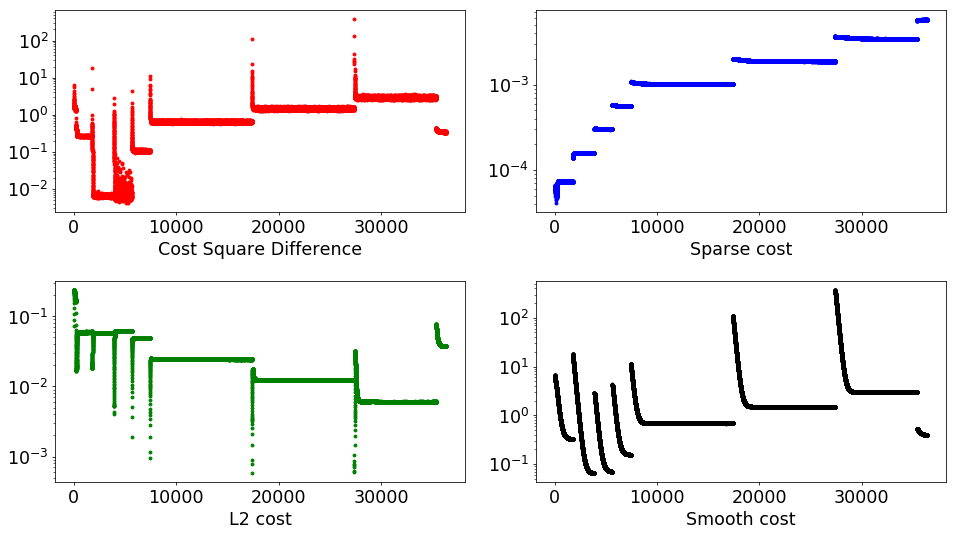

In [28]:
cost_base += ae.cost_base_list
cost_l2 += ae.reg_l2_list
cost_sparse += ae.reg_sparse_list
cost_smooth += ae.cost_list
    
figure(figsize=(14,8))

subplot(2,2,1)
semilogy(cost_base,'r.')
xlabel('Cost Square Difference');

subplot(2,2,2)
semilogy(cost_sparse,'b.')
xlabel('Sparse cost');

subplot(2,2,3)
semilogy(cost_l2,'g.')
xlabel('L2 cost');

subplot(2,2,4)
semilogy(cost_smooth,'k.')
xlabel('Smooth cost');

tight_layout()

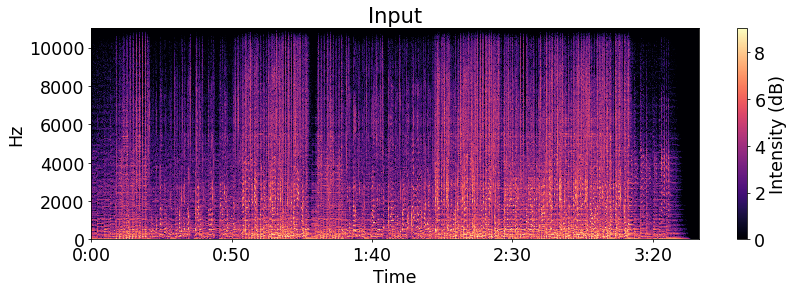

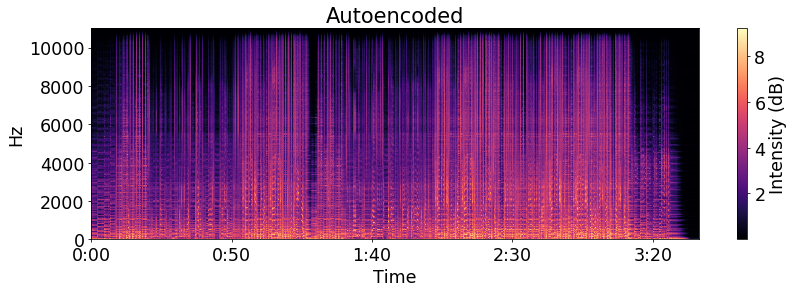

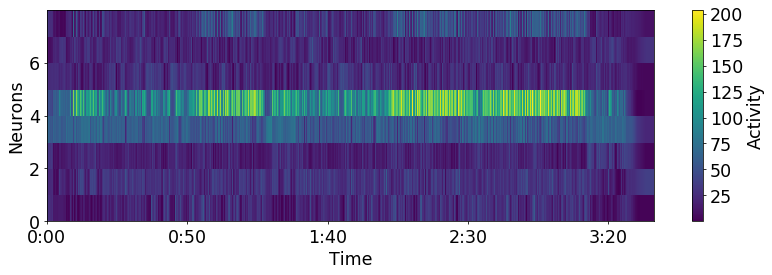

In [29]:
sess = ae.get_session()
variable_dict = ae.get_variables_dict()

SAVEFIG = False

duration = track.size/fs
compare = range(0,time_bins,1)
recon = sess.run(variable_dict['Y'], feed_dict={ variable_dict['X']: data.data[compare]})

orig = data.data[compare]
M = orig*scaler[0]+scaler[1]

figure(figsize=(14,4))

librosa.display.specshow(M.T,hop_length = HOP,sr=fs,y_axis='linear', fmax=8000, x_axis='time')

title('Input')
colorbar(label='Intensity (dB)')
if SAVEFIG:plt.savefig('figs/original')

M = recon*scaler[0]+scaler[1]

figure(figsize=(14,4))

librosa.display.specshow(M.T,hop_length = HOP,sr=fs,y_axis='linear', fmax=8000, x_axis='time')

title('Autoencoded');
colorbar(label='Intensity (dB)');
if SAVEFIG: plt.savefig('figs/ae')
    
figure(figsize=(14,4))
Z = sess.run(variable_dict['z'], feed_dict={ variable_dict['X']: data.data[compare]})
idx = np.lexsort(Z)
librosa.display.specshow(Z.T,hop_length = HOP,sr=fs, x_axis='time',cmap=cm.viridis)
yticks(range(0,Z[0].size,2))
ylabel('Neurons')
colorbar(label='Activity')
if SAVEFIG: plt.savefig('figs/Z')

In [30]:
from IPython.display import Audio, display

M = recon*scaler[0]+scaler[1]

M_ = zeros((M.shape[0],M.shape[1]+1),dtype=float32)
M_[:,:M.shape[1]] = sqrt(10**(M))
M_ = M_*angle(STFT)

out = librosa.istft(M_.T,hop_length=HOP, win_length=NFFT, center=True)

# display(Audio(data=out,rate=fs))
# display(Audio(data=track,rate=fs))
librosa.output.write_wav('wavs/'+filename+'.wav',out,sr=fs)

In [14]:
W = sess.run(variable_dict['W'], feed_dict={ variable_dict['X']: data.data[compare]})

In [15]:
# for i in range(len(dimensions)-1,-1,-1):
#     figure(figsize=(10,8))
#     print(W[i].min(),W[i].max())
#     imshow(W[i],aspect='auto',cmap=cm.seismic,vmin=-0.5,vmax=0.5)